## GET DATA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! git clone https://github.com/fransoa2607/bva.git

Cloning into 'bva'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 108 (delta 46), reused 95 (delta 33), pack-reused 0
Receiving objects: 100% (108/108), 7.29 MiB | 7.85 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [3]:
%env PYTHONPATH="$/env/python:/content/bva"
! echo $PYTHONPATH

env: PYTHONPATH="$/env/python:/content/bva"
"$/env/python:/content/bva"


In [4]:
cd ./bva/bva/

/content/bva/bva


In [5]:
from preprocess import get_all_videos_sequences_by_window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [6]:
video_url = "/content/bva/bva/data/video_details.csv"
clean_df = "/content/bva/bva/data/clean_dataset.csv"

In [11]:
df_shots, all_videos_sequences, all_videos_targets, test_dict = get_all_videos_sequences_by_window(video_url, clean_df, 6, 5)

In [12]:
# Features and target
X_all = all_videos_sequences
y_all = all_videos_targets
print(X_all.shape)
print(y_all.shape)

(43645, 5, 11)
(43645,)


In [17]:
# encoding categorical target
label_encoder = LabelEncoder()
y_all_enc = label_encoder.fit_transform(y_all)
y_cat = to_categorical(y_all_enc)

In [19]:
y_all_enc[:30]

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 13, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [26]:
y_cat.shape

(43645, 14)

In [27]:
#train test split
X_train, X_val, y_train, y_val = train_test_split(X_all, y_cat, test_size=0.2)

In [51]:
X_train[0]

array([[1.        , 0.4734375 , 0.48472222, 0.33046875, 0.51111111,
        0.6890625 , 0.51527778, 0.77265625, 0.94444444, 0.17265625,
        0.93055556],
       [1.        , 0.4734375 , 0.48333333, 0.33046875, 0.51111111,
        0.6890625 , 0.51527778, 0.77265625, 0.94444444, 0.17265625,
        0.93055556],
       [1.        , 0.475     , 0.48333333, 0.33046875, 0.51111111,
        0.6890625 , 0.51527778, 0.77265625, 0.94444444, 0.17265625,
        0.93055556],
       [1.        , 0.47421875, 0.48055556, 0.33046875, 0.51111111,
        0.6890625 , 0.51527778, 0.77265625, 0.94444444, 0.17265625,
        0.93055556],
       [1.        , 0.475     , 0.48055556, 0.33046875, 0.51111111,
        0.6890625 , 0.51527778, 0.77265625, 0.94444444, 0.17265625,
        0.93055556]])

In [30]:
# Modèle de classification
def init_model():
  model = Sequential()
  # model.add(layers.Masking(mask_value=-1000, input_shape=(50,2))) => no padding
  model.add(layers.GRU(units=64, activation='tanh', return_sequences=True))
  model.add(layers.GRU(units=32, activation='tanh', return_sequences=True))
  model.add(layers.GRU(units=24, activation='tanh', return_sequences=False))
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dropout(rate=0.2))
  model.add(layers.Dense(30, activation='relu'))
  model.add(layers.Dropout(rate=0.2))
  model.add(layers.Dense(14, activation='softmax'))
  # Compilation
  model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=0.001),
                metrics=["accuracy"])
  return model

In [31]:
model = init_model()
model.build(X_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (34916, 5, 64)            14784     
                                                                 
 gru_1 (GRU)                 (34916, 5, 32)            9408      
                                                                 
 gru_2 (GRU)                 (34916, 24)               4176      
                                                                 
 dense (Dense)               (34916, 50)               1250      
                                                                 
 dropout (Dropout)           (34916, 50)               0         
                                                                 
 dense_1 (Dense)             (34916, 30)               1530      
                                                                 
 dropout_1 (Dropout)         (34916, 30)               0

In [ ]:
# Fitting
es = EarlyStopping(patience=30, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=16, callbacks=[es])

In [ ]:
history.history

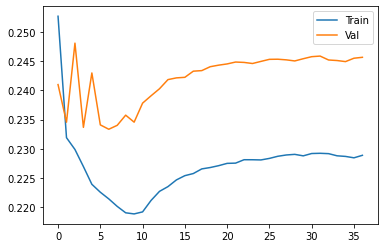

In [35]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend();

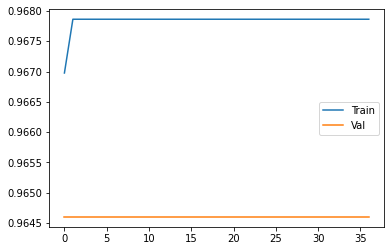

In [36]:
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.legend();

## TESTS

In [37]:
test_dict.keys()

dict_keys(['match9/rally_video/1_02_03.mp4', 'match9/rally_video/1_04_05.mp4', 'match9/rally_video/1_05_06.mp4', 'match9/rally_video/1_07_10.mp4', 'match9/rally_video/1_07_11.mp4'])

In [38]:
X_test = test_dict['match9/rally_video/1_02_03.mp4'][0]

In [39]:
y_test = test_dict['match9/rally_video/1_02_03.mp4'][1]
y_test_cat = to_categorical(label_encoder.transform(y_test))

In [40]:
X_test.shape

(298, 5, 11)

In [41]:
y_test_cat.shape

(298, 14)

In [42]:
# Eval
model.evaluate(X_test, y_test_cat)

10/10 [==============================] - 0s 4ms/step - loss: 0.2808 - accuracy: 0.9564


[0.28080952167510986, 0.9563758373260498]

## Predict

In [43]:
X_to_pred = test_dict['match9/rally_video/1_02_03.mp4'][0]

In [44]:
y_pred = model.predict(X_to_pred)

In [45]:
y_pred.shape

(298, 14)

In [48]:
pred_df = pd.DataFrame(y_pred, columns=label_encoder.classes_)
pred_df

,clear,drive,drop,full_smash,half_smash,lift,lob,long_def,long_serve,net_kill,net_shot,no_hit,short_def,short_serve
0,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397
1,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397
2,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397
3,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397
4,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397
294,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397
295,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397
296,0.002681,0.001565,0.002859,0.00143,0.002934,0.000184,0.007717,0.000051,0.000131,0.000048,0.007408,0.966981,0.004614,0.001397


In [ ]:
y_truth = test_dict['match9/rally_video/1_02_03.mp4'][1]

In [ ]:
y_truth

In [ ]:
label_encoder.classes_

array(['clear', 'drive', 'drop', 'full_smash', 'half_smash', 'lift',
       'lob', 'long_def', 'long_serve', 'net_kill', 'net_shot', 'no_hit',
       'short_def', 'short_serve'], dtype='<U32')